<a href="https://colab.research.google.com/github/shangong/fastai/blob/master/fastai-image_classifier_plants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Building an Image Classifier using Transfer Learning

###Motivation
I am currently doing a fast.ai Live MOOC called “Practical Deep learning for Coders” which will be publically available in January 2019 on fast.ai website. The following code is based on lesson 1 from that course. I will be using fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In the below example you will see how ridiculously easy is to do transfer learning and achieve world-class results on [Plant Vintage](https://plantvillage.psu.edu) [Dataset](https://drive.google.com/file/d/0B_voCy5O5sXMTFByemhpZllYREU/view). PlantVintage data have images of plant leaves which consist of 38 disease classes which are commonly found on crops and one background class from Stanford’s open dataset of background images — [DAGS](http://dags.stanford.edu/projects/scenedataset.html).

Source: https://towardsdatascience.com/transfer-learning-using-the-fastai-library-d686b238213e by Aayush Agrawal/ [LinkedIn](https://www.linkedin.com/in/aayushmnit/) or email at aayushmnit@gmail.com.

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
#bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

Download the PlantVintage Dataset at https://drive.google.com/file/d/0B_voCy5O5sXMTFByemhpZllYREU/view.

Another project is https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases.


In [0]:
#import libraries for uploading data
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#create a drive variable to access Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#https://drive.google.com/file/d/1IXHDHbIUR6jbFjrQ4kCyyN8fsLyeLbyn/view?usp=sharing
download = drive.CreateFile({'id': '1IXHDHbIUR6jbFjrQ4kCyyN8fsLyeLbyn'})

In [11]:
download.GetContentFile('plantvillage.zip')
#unzip the plantvillage.zip file
!unzip plantvillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/val/Tomato___Septoria_leaf_spot/._5e23a1a8-d7b8-4bf4-9f02-941159d8ed44___JR_Sept.L.S 8382.JPG  
  inflating: val/Tomato___Septoria_leaf_spot/f43ce703-8d4d-4e97-8e23-788f56338c09___Matt.S_CG 6660.JPG  
  inflating: __MACOSX/val/Tomato___Septoria_leaf_spot/._f43ce703-8d4d-4e97-8e23-788f56338c09___Matt.S_CG 6660.JPG  
  inflating: val/Tomato___Septoria_leaf_spot/02ab6821-757a-401b-ac04-919fdceee1f0___Matt.S_CG 1653.JPG  
  inflating: __MACOSX/val/Tomato___Septoria_leaf_spot/._02ab6821-757a-401b-ac04-919fdceee1f0___Matt.S_CG 1653.JPG  
  inflating: val/Tomato___Septoria_leaf_spot/ac96d4d4-4eb0-4ed8-9954-b38306e120cf___Matt.S_CG 2749.JPG  
  inflating: __MACOSX/val/Tomato___Septoria_leaf_spot/._ac96d4d4-4eb0-4ed8-9954-b38306e120cf___Matt.S_CG 2749.JPG  
  inflating: val/Tomato___Septoria_leaf_spot/0a95b5b7-7bfb-4201-9320-dae33498081a___JR_Sept.L.S 2482.JPG  
  inflating: __MACOSX/val/Tomato___Septoria_leaf_spot/._0a95b

In [12]:
!ls -al

total 871584
drwxr-xr-x  1 root root      4096 Mar  9 14:07 .
drwxr-xr-x  1 root root      4096 Mar  9 14:00 ..
-rw-r--r--  1 root root      2624 Mar  9 14:06 adc.json
drwxr-xr-x  1 root root      4096 Mar  9 14:06 .config
lrwxrwxrwx  1 root root        18 Mar  9 14:02 data -> /root/.fastai/data
drwx------  4 root root      4096 Mar  9 14:02 gdrive
drwxr-xr-x  4 root root      4096 Mar  9 14:07 __MACOSX
lrwxrwxrwx  1 root root        19 Mar  9 14:02 models -> /root/.torch/models
-rw-r--r--  1 root root 892454254 Mar  9 14:07 plantvillage.zip
drwxr-xr-x 41 root root      4096 Jul 21  2017 train
drwxr-xr-x 41 root root      4096 Jul 21  2017 val


In [0]:
!pwd

/content


##Looking at the data
The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like. Our data is already split in train and validation folder, and inside each subdirectory, our folder name represents the class name of all the images present within that subfolder. Fortunately, the fastai library has a handy function made exactly for this, [ImageDataBunch.from_folder](https://docs.fast.ai/vision.data#ImageDataBunch.from_folder) gets the label names from the folder name automatically. fastai library has awesome documentation to navigate through their library functions with live examples on how to use them. Once the data is loaded, we can also normalize the data by using .normalize to ImageNet parameters.

In [13]:
## Declaring path of dataset
path_img = Path('/content')

## Loading data
tfms = get_transforms()
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='val', ds_tfms=tfms, size=224, bs=bs)

## Normalizing data based on Image net parameters
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (44016 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot
Path: /content;

Valid: LabelList (11004 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot,Apple___Black_rot
Path: /content;

Test: None

To look at a random sample of images, we can use .show_batch() function ImageDataBunch class. As we can see below, we have some cases of diseases leaf on different crops plus some background noise images from DAGS dataset which will act as noise.

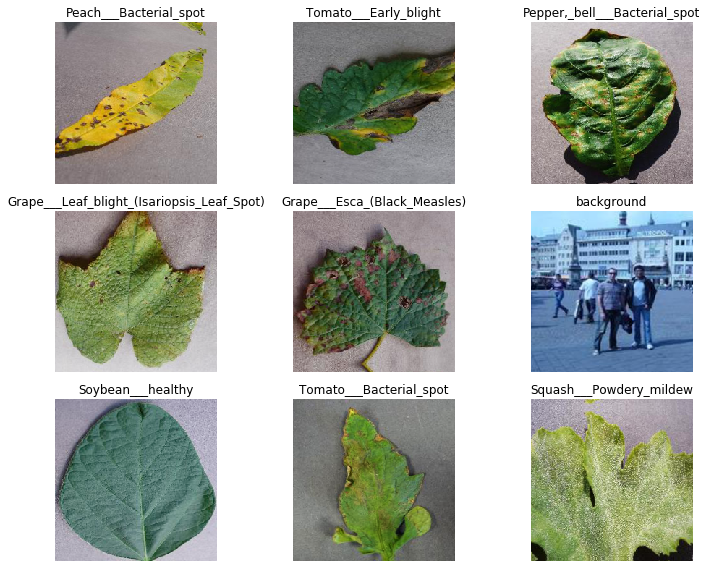

In [0]:
data.show_batch(rows=3, figsize=(10,8))

Let’s print all the data classes present in the database. In total, we have images in 39 classes as mentioned above in the motivation section.

In [0]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

So we have the


*   pictures and the labels to train the model with
*   from_name_re = get label from the name using regular expression
*   a Data Bunch is to collect all these data





## Training: resnet34

##Transfer learning using a pre-trained model: ResNet 34
Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone ResNet34 and a fully connected head with a single hidden layer as a classifier.

You can also read the ResNet paper if you want to understand all the architectural detail. To create the transfer learning model we will need to use function create_cnn from Learner class and feed a pre-trained model from models class.

Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [14]:
#To create a ResNet34 with pretrained weights
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
#The ResNet34 model created by create_cnn function have initial layers frozen, and we are just going to learn weights of the last fully connected layers.
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.364807,0.160732,0.049800,09:11
1,0.230728,0.077365,0.023628,09:21
2,0.163552,0.044971,0.013450,09:22
3,0.093817,0.029543,0.008088,09:19
4,0.064705,0.026225,0.007543,09:18


As we can see above by just running five epochs with the default setting our accuracy for this fine-grained classification task is around ~99.64% on the validation dataset. Let’s save the model as we are going to fine tune it later. If you want to know how good this result is, it already beats the shallow learning(only training last layer) benchmark of 96.53% from this Github Page.

## Some notes on using Deep Learning:


### Model

the learning model, object's denoted as `cnn_learner`, used an existing, pre-trained model called resnet `models.resnet34` (at the time of writing my notes, I read up on it and got confused so no explaination), 34 is the bits so there are 2 choices here (34 and 50).

> learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Jeremy spent quick a lot of time explaining that his approach is Transfer Learning, https://en.wikipedia.org/wiki/Transfer_learning, and it makes sense to use what others have built.

### Architecture of the model

Next, we're interested in training this model for our use-case. We do this by "fitting" and the state-of-the-art method's `fit_one_cycle` (the other method is `fit`).

> learn.fit_one_cycle(4)

Basically, what we have done is trained our instance of resnet with all the different pictures of dog and cat breeds (data bunch of pictures and labels).

In [0]:
learn.save('plant_vintage_stage1-9Mar2020_v1')

FastAI library also provides functions to explore results faster and find if our model is learning what it is supposed to learn. We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not using ClassificationInterpretation class.

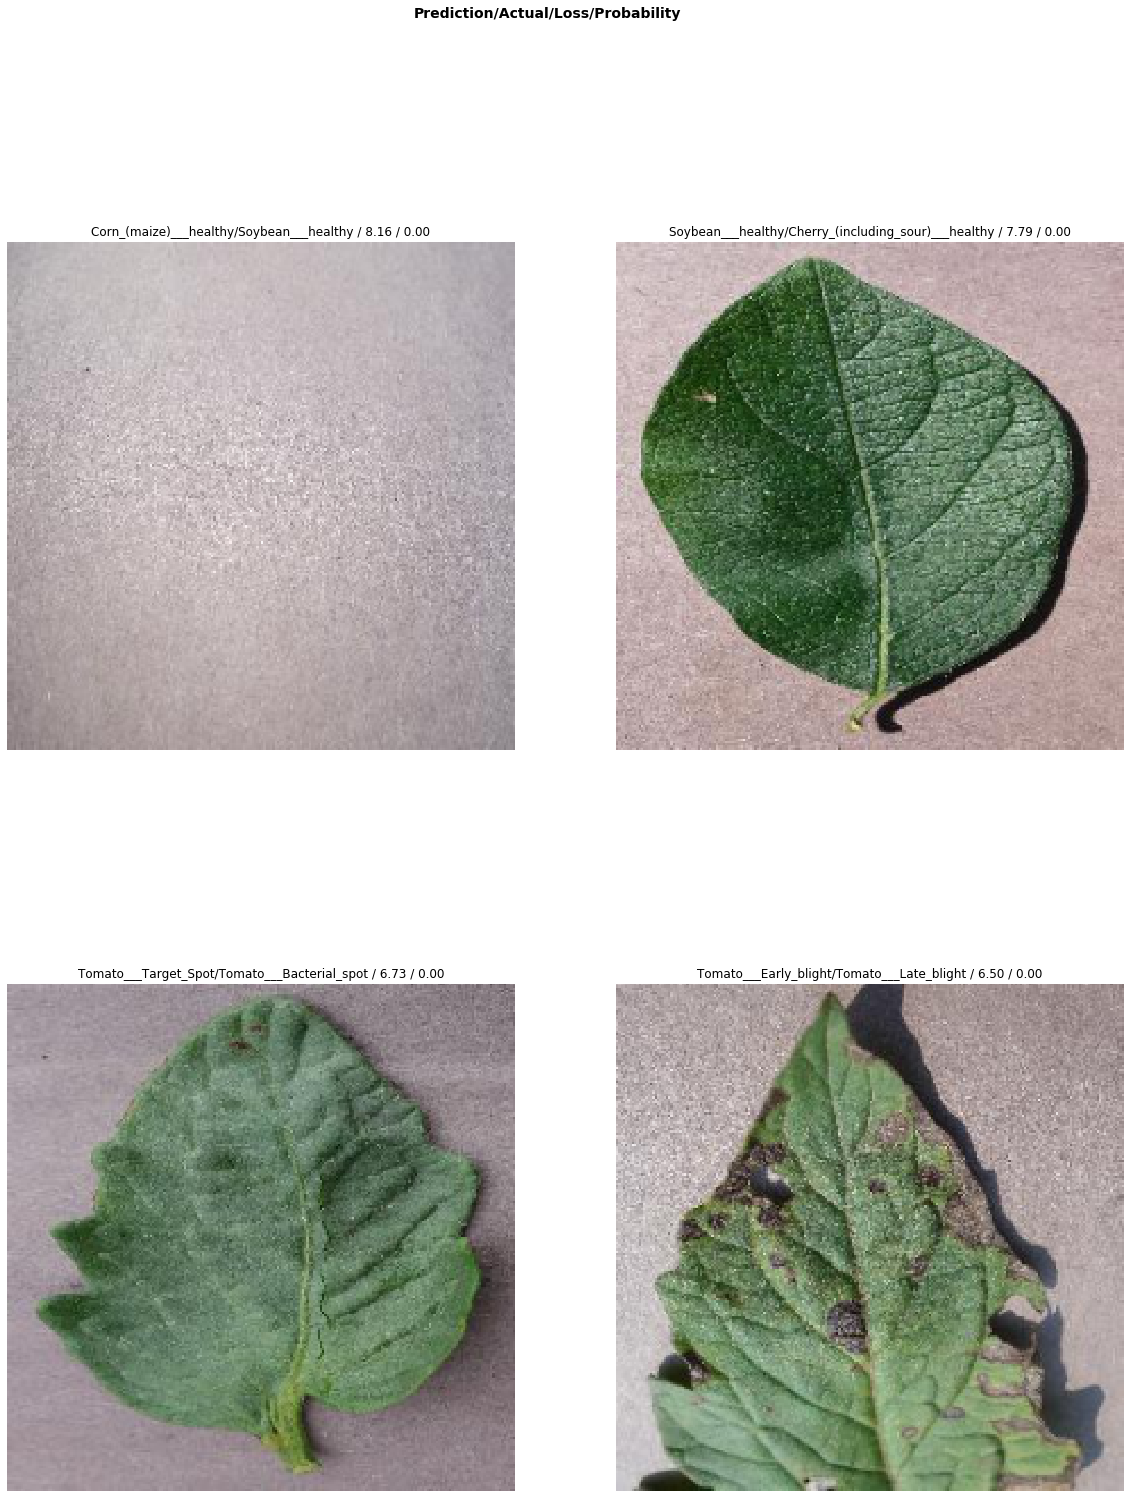

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(20,25))

In this case, the model is getting confused in detecting Tomato's Late Blight from Bacterial spots on the Tomato left. This is an indicator that the classifier is working correctly.

### Understanding the results

So to understand how good our model has "learnt" (can tell 1 breed from the other), we'll do these list of steps:

1. use the `ClassificationInterpretation` and put the learn object in.
1. look at the result with `interp.plot_top_losses`

> interp = ClassificationInterpretation.from_learner(learn)
>
> losses,idxs = interp.top_losses()
>
> len(data.valid_ds)==len(losses)==len(idxs)

p.s. **Don't understand how to use** `plot_top_losses`?... no worries, the guide's (link is above but I'm pasting it here as well, https://docs.fast.ai/vision.learner.html#_cl_int_plot_top_losses) explains the function well.

-> The title of each image shows: prediction, actual, loss, probability of actual class.

If it still isn't very clear, we have other tools for this:


*   the confusion matrix = `plot_confusion_matrix` and
*   Jeremy's `most_confused` function

Furthermore, when we plot the confusion matrix, we can see that most of the things are classified correctly, and it’s almost a near perfect model.

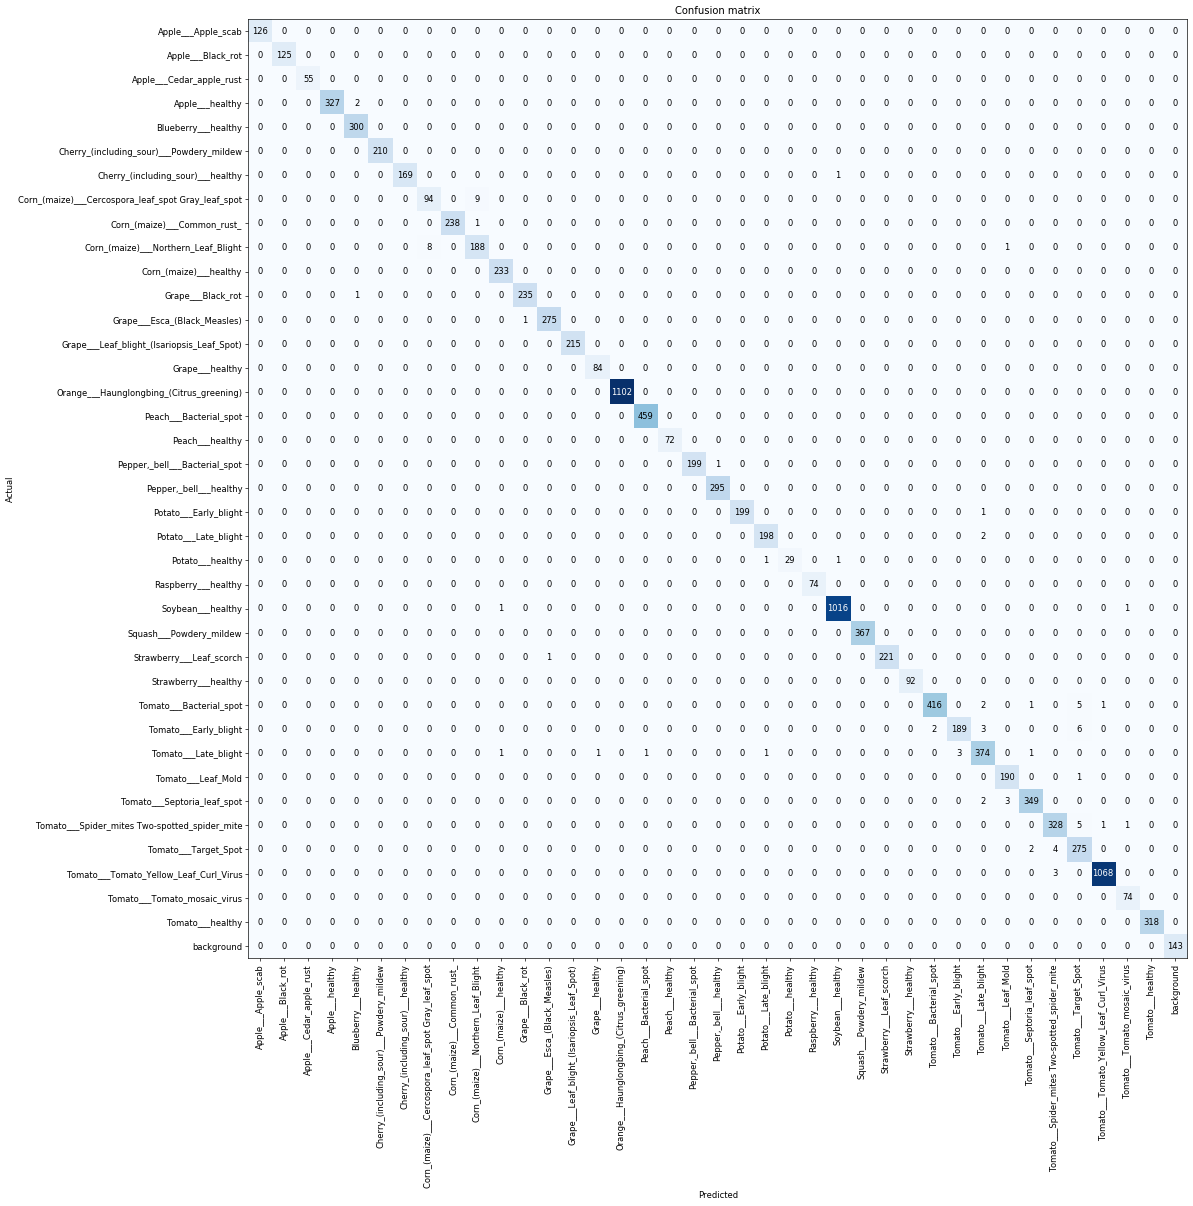

In [19]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Northern_Leaf_Blight',
  9),
 ('Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  8),
 ('Tomato___Early_blight', 'Tomato___Target_Spot', 6),
 ('Tomato___Bacterial_spot', 'Tomato___Target_Spot', 5),
 ('Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 5),
 ('Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 4),
 ('Tomato___Early_blight', 'Tomato___Late_blight', 3),
 ('Tomato___Late_blight', 'Tomato___Early_blight', 3),
 ('Tomato___Septoria_leaf_spot', 'Tomato___Leaf_Mold', 3),
 ('Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  3),
 ('Apple___healthy', 'Blueberry___healthy', 2),
 ('Potato___Late_blight', 'Tomato___Late_blight', 2),
 ('Tomato___Bacterial_spot', 'Tomato___Late_blight', 2),
 ('Tomato___Early_blight', 'Tomato___Bacterial_spot', 2),
 ('Tomato___Septoria_leaf_spot', 'Tom

So until now, we have only been training the last classification layers, but what if we want to optimize earlier layers too. In transfer learning, tweaking initial layers should be done with caution, and the learning rate should be kept pretty low. FastAI library provides a function to see what will be the ideal learning rate to train upon, so let’s plot it. The lr_find function runs the model for a subset of data at multiple learning rate to determine which learning rate would be best.

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


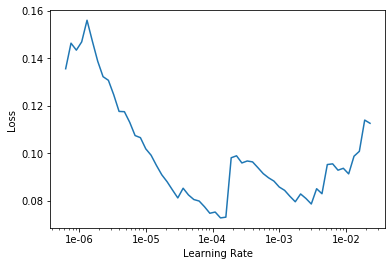

In [20]:
learn.lr_find()
learn.recorder.plot()

It looks like we should keep our learning rate between 10e-5 to 10e-2 as it spikes up at lower than 10e-5 and higher than 10e-2. So we can use slice function to logarithmically distribute learning rate between 10e-5 to 10e-2 for different layers in the network. Keeping the lowest learning rate for the initial layers and increasing it for later layers. Let’s unfreeze all the layers so that we can train the entire model using unfreeze() function.

In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-2)) #slice(1e-5,1e-2) 5 to 3.5 is actually the best

epoch,train_loss,valid_loss,error_rate,time
0,0.253120,0.086176,0.025445,10:49
1,0.053215,0.021917,0.006725,10:45


As we can see by training all the layers, we improved our accuracy to 99.7% which is comparable to 99.76% on the [Github benchmark](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases) using Inception-v3 model.

In [0]:
learn.save('plant_vintage_stage1b-9Mar2020_v1');

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


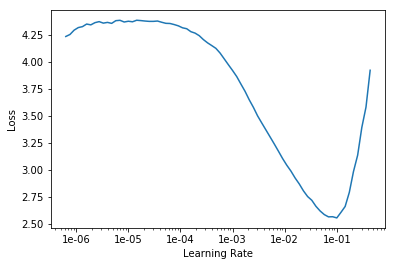

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_sample/train'),
 PosixPath('/root/.fastai/data/mnist_sample/valid')]

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_sample/train/7'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3')]

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

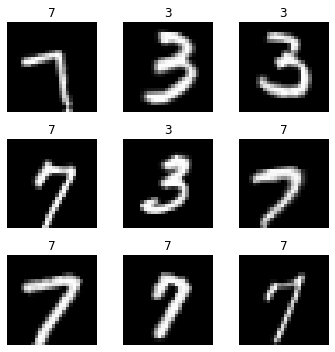

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

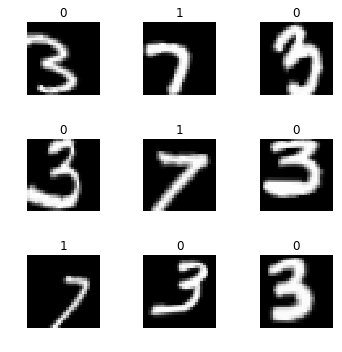

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']